In [1]:
import torch
print('GPU not found.') if not torch.cuda.is_available() else print(f'Found GPU: {torch.cuda.get_device_name(0)}')

Found GPU: NVIDIA GeForce RTX 3070


In [2]:
# Cell 1: 라이브러리 import
import torch
from utils.cnn.classifier import initialize_cnn_classifier
from utils.cnn.dataset_functions import create_cnn_dataset, unwrap_client_data, get_label_mapping
from utils.cnn.federated_averaging import federated_averaging
from utils.cnn.visualization import plot_training_curves, visualize_predictions

In [3]:
# Cell 2: 데이터 경로 및 클라이언트 분배 설정
data_dir = 'data'  # 또는 'merged_data'
imagePath0 = f'{data_dir}/0/'
imagePath1 = f'{data_dir}/1/'
npyPath = f'{data_dir}/annotations/'

# 파일 분배 (예: 693개 파일을 8개 클라이언트에 분배)
total_files = 693
num_clients = 8
files_per_client = total_files // num_clients

clientIdentifierDict = {}
start = 1

for i in range(1, num_clients + 1):
    if i < num_clients:
        end = start + files_per_client - 1
    else:
        end = total_files
    
    file_list = [f'{j:06d}' for j in range(start, end + 1)]
    clientIdentifierDict[f'client{i}'] = file_list
    print(f'client{i}: {start:06d} ~ {end:06d} ({len(file_list)}개 파일)')
    start = end + 1


client1: 000001 ~ 000086 (86개 파일)
client2: 000087 ~ 000172 (86개 파일)
client3: 000173 ~ 000258 (86개 파일)
client4: 000259 ~ 000344 (86개 파일)
client5: 000345 ~ 000430 (86개 파일)
client6: 000431 ~ 000516 (86개 파일)
client7: 000517 ~ 000602 (86개 파일)
client8: 000603 ~ 000693 (91개 파일)


In [4]:
# Cell 3: 레이블 매핑 생성
label_mapping, num_classes = get_label_mapping(data_dir, clientIdentifierDict)

발견된 결함 유형: [np.int8(-1), np.int8(0), np.int8(1), np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9), np.int8(11), np.int8(14), np.uint8(255)]
레이블 매핑: {np.int8(-1): 0, np.int8(0): 1, np.int8(1): 2, np.int8(3): 3, np.int8(4): 4, np.int8(5): 5, np.int8(6): 6, np.int8(7): 7, np.int8(8): 8, np.int8(9): 9, np.int8(11): 10, np.int8(14): 11, np.uint8(255): 12}
총 클래스 수: 13


각 결함 유형별 이미지 검색 중... (최소 픽셀 수: 150개 이상)
  발견: 결함 유형 0 -> 000244 (픽셀 수: 3864368)
  발견: 결함 유형 1 -> 000292 (픽셀 수: 804269)
  발견: 결함 유형 8 -> 000001 (픽셀 수: 116608)
  발견: 결함 유형 4 -> 000276 (픽셀 수: 42111)
  발견: 결함 유형 5 -> 000342 (픽셀 수: 3180)
  발견: 결함 유형 6 -> 000566 (픽셀 수: 43345)
  발견: 결함 유형 11 -> 000292 (픽셀 수: 53687)
  발견: 결함 유형 9 -> 000518 (픽셀 수: 3012)
  발견: 결함 유형 -1 -> 000678 (픽셀 수: 80055)
  발견: 결함 유형 3 -> 000534 (픽셀 수: 15871)
  발견: 결함 유형 7 -> 000276 (픽셀 수: 207070)
  발견: 결함 유형 14 -> 000292 (픽셀 수: 2986)
  발견: 결함 유형 255 -> 000682 (픽셀 수: 80055)

총 13개 결함 유형의 샘플 이미지 발견


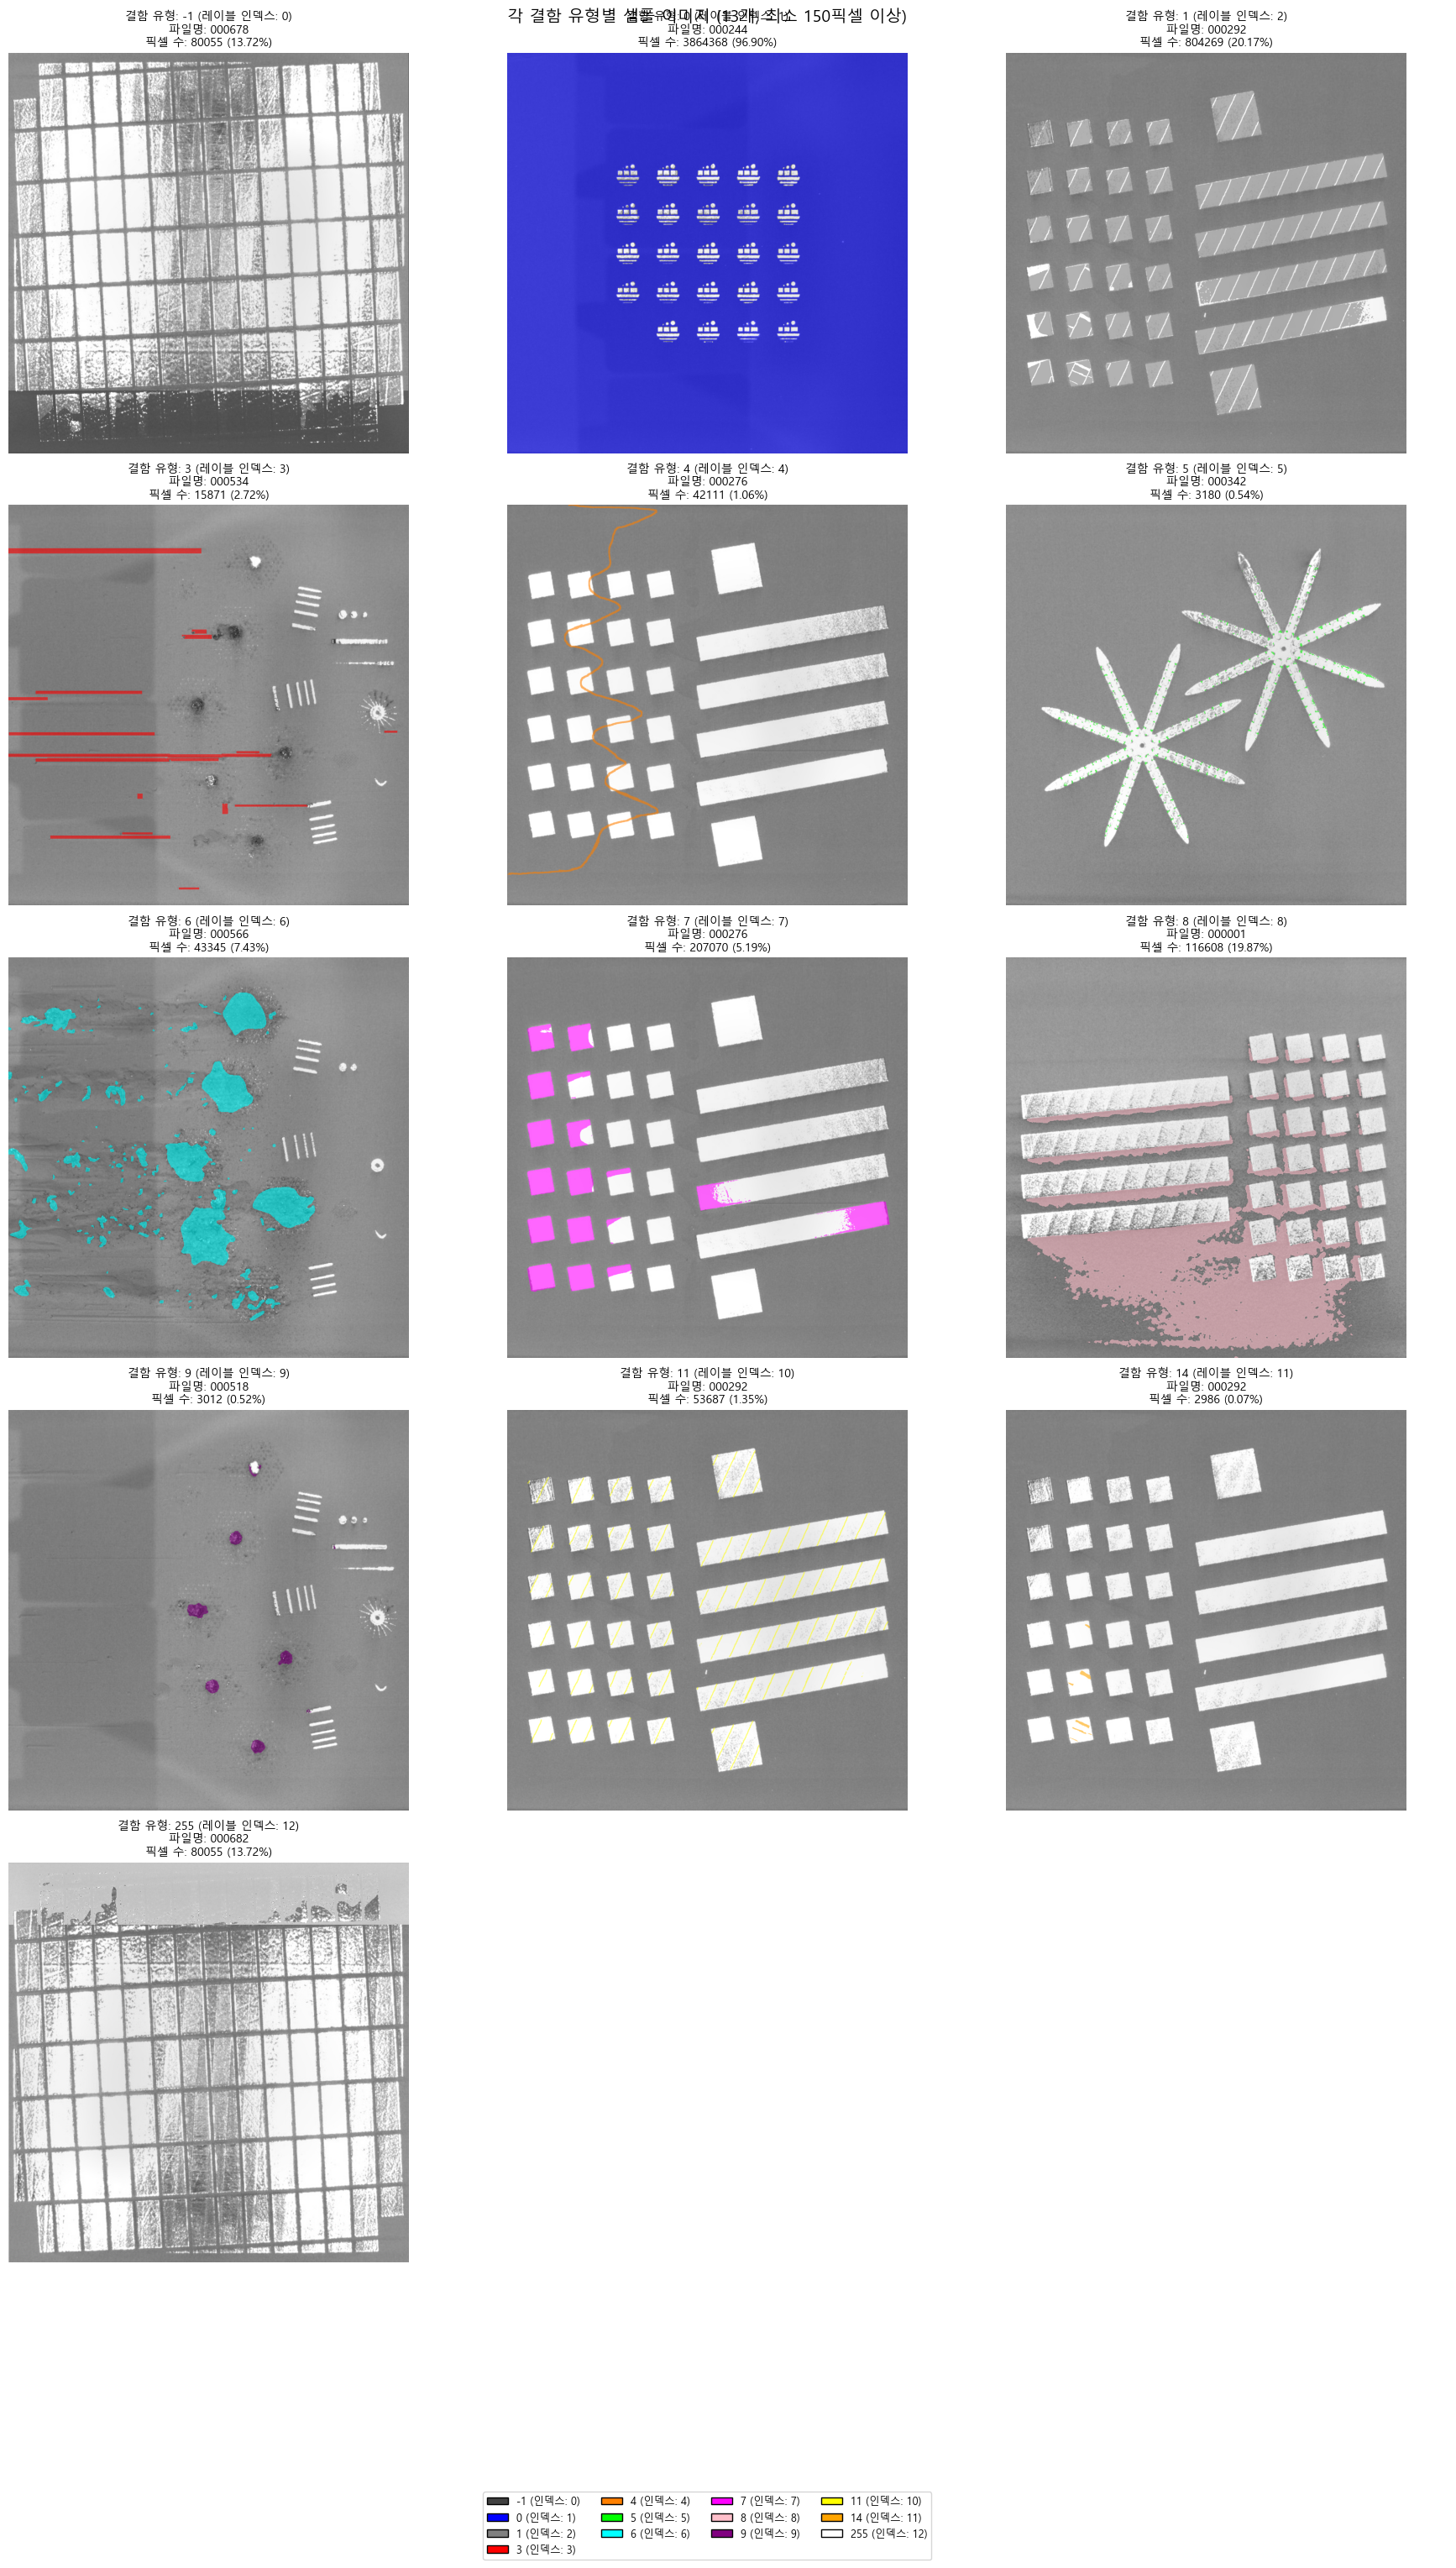


=== 결함 유형별 샘플 통계 ===

결함 유형 -1 (레이블 인덱스: 0):
  - 샘플 파일: 000678
  - 픽셀 수: 80055 (13.72%)
  - 마스크 크기: (764, 764)

결함 유형 0 (레이블 인덱스: 1):
  - 샘플 파일: 000244
  - 픽셀 수: 3864368 (96.90%)
  - 마스크 크기: (1997, 1997)

결함 유형 1 (레이블 인덱스: 2):
  - 샘플 파일: 000292
  - 픽셀 수: 804269 (20.17%)
  - 마스크 크기: (1997, 1997)

결함 유형 3 (레이블 인덱스: 3):
  - 샘플 파일: 000534
  - 픽셀 수: 15871 (2.72%)
  - 마스크 크기: (764, 764)

결함 유형 4 (레이블 인덱스: 4):
  - 샘플 파일: 000276
  - 픽셀 수: 42111 (1.06%)
  - 마스크 크기: (1997, 1997)

결함 유형 5 (레이블 인덱스: 5):
  - 샘플 파일: 000342
  - 픽셀 수: 3180 (0.54%)
  - 마스크 크기: (764, 764)

결함 유형 6 (레이블 인덱스: 6):
  - 샘플 파일: 000566
  - 픽셀 수: 43345 (7.43%)
  - 마스크 크기: (764, 764)

결함 유형 7 (레이블 인덱스: 7):
  - 샘플 파일: 000276
  - 픽셀 수: 207070 (5.19%)
  - 마스크 크기: (1997, 1997)

결함 유형 8 (레이블 인덱스: 8):
  - 샘플 파일: 000001
  - 픽셀 수: 116608 (19.87%)
  - 마스크 크기: (766, 766)

결함 유형 9 (레이블 인덱스: 9):
  - 샘플 파일: 000518
  - 픽셀 수: 3012 (0.52%)
  - 마스크 크기: (764, 764)

결함 유형 11 (레이블 인덱스: 10):
  - 샘플 파일: 000292
  - 픽셀 수: 53687 (1.35%)
  - 마스크 크기: (19

In [5]:
# Cell에 추가
from utils.visual_npy import visualize_defect_types_samples

visualize_defect_types_samples(data_dir, clientIdentifierDict, label_mapping, min_pixels=150)

In [ ]:
# Cell 4: 데이터셋 생성
target_size = (640, 640)
print("\n데이터셋 생성 중...")
imageDict, labelDict = create_cnn_dataset(
    clientIdentifierDict,
    data_dir,
    target_size=target_size,
    label_mapping=label_mapping
)


데이터셋 생성 중...
client1...
  처리 중: 50/86 파일 완료
Contains 86 images...
Valid images: 86 (filtered 0 invalid labels)
Image Tensor Shape: torch.Size([86, 2, 640, 640])
Label Shape: torch.Size([86])
Label distribution: Counter({np.int64(1): 86})
client2...
  처리 중: 50/86 파일 완료
Contains 86 images...
Valid images: 86 (filtered 0 invalid labels)
Image Tensor Shape: torch.Size([86, 2, 640, 640])
Label Shape: torch.Size([86])
Label distribution: Counter({np.int64(1): 86})
client3...
  처리 중: 50/86 파일 완료
Contains 86 images...
Valid images: 86 (filtered 0 invalid labels)
Image Tensor Shape: torch.Size([86, 2, 640, 640])
Label Shape: torch.Size([86])
Label distribution: Counter({np.int64(1): 86})
client4...
  처리 중: 50/86 파일 완료
Contains 86 images...
Valid images: 86 (filtered 0 invalid labels)
Image Tensor Shape: torch.Size([86, 2, 640, 640])
Label Shape: torch.Size([86])
Label distribution: Counter({np.int64(1): 86})
client5...


In [ ]:
# Cell 5: Train/Test 분할
trainClients = ['client1', 'client2', 'client3', 'client4', 
                'client5', 'client7', 'client8']
testClients = ['client6']

clientIDs = trainClients

# Train Data
trainImageDict = {clientID: imageDict[clientID] for clientID in trainClients}
trainLabelDict = {clientID: labelDict[clientID] for clientID in trainClients}

# Test Data
testImageDict = {clientID: imageDict[clientID] for clientID in testClients}
testLabelDict = {clientID: labelDict[clientID] for clientID in testClients}

testImages, testLabels = unwrap_client_data(testImageDict, testLabelDict, testClients)


In [ ]:
# 레이블 검증
print("\n레이블 범위 검증:")
for clientID in clientIDs:
    labels = trainLabelDict[clientID]
    min_label = labels.min().item()
    max_label = labels.max().item()
    invalid_count = ((labels < 0) | (labels >= num_classes)).sum().item()
    print(f"{clientID}: min={min_label}, max={max_label}, invalid={invalid_count}")
    if invalid_count > 0:
        print(f"  경고: {clientID}에 유효하지 않은 레이블이 {invalid_count}개 있습니다!")

In [ ]:
# Cell 6: 하이퍼파라미터 설정
SERVER_ROUNDS = 3
LOCAL_EPOCHS = 3
LOCAL_BATCH_SIZE = 32
LOCAL_LEARNING_RATE = 1e-4

In [ ]:
# Cell 7: 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = initialize_cnn_classifier(num_classes, input_channels=2, device=device)
print(f"모델 초기화 완료! 클래스 수: {num_classes}")


In [ ]:
# Cell 8: 연합학습 실행
model, serverStateDict, lossDict, testLoss, accuracyDict, testAccuracy = federated_averaging(
    model,
    SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE, LOCAL_LEARNING_RATE,
    clientIDs, trainImageDict, trainLabelDict,
    testImages, testLabels,
    device=device
)

In [ ]:
# Cell 9: 학습 곡선 시각화
plot_training_curves(lossDict, accuracyDict, testLoss, testAccuracy, clientIDs)


In [ ]:
# Cell 10: 모델 저장
import os
from utils.cnn.classifier import save_cnn_model

os.makedirs('saved_models', exist_ok=True)

test_set_name = ''.join([c.replace('client', '') for c in testClients])
if len(test_set_name) == 1:
    test_set_name = '0' + test_set_name

lr_str = f"{LOCAL_LEARNING_RATE:.0e}".replace('-', '').replace('+', '').replace('.0', '')
base_filename = f'saved_models/CNN_FL_{SERVER_ROUNDS}_{LOCAL_EPOCHS}_{LOCAL_BATCH_SIZE}_{lr_str}_HoldoutPart{test_set_name}.pth'

model_filename = base_filename
counter = 1
while os.path.exists(model_filename):
    base_name, ext = os.path.splitext(base_filename)
    model_filename = f'{base_name}_{counter}{ext}'
    counter += 1

save_cnn_model(model, model_filename, num_classes=num_classes)
print(f'\n최종 테스트 성능:')
print(f'  Loss: {testLoss[-1]:.4f}')
print(f'  Accuracy: {testAccuracy[-1]:.2f}%')


In [ ]:
# Cell 11: 예측 결과 시각화
visualize_predictions(
    model, testImageDict, testLabelDict, testClients,
    clientIdentifierDict, data_dir, num_samples=6, device=device
)